# Celltype Classification with Transcriptformer

This notebooks showcase how the Transcriptformer embeddings can be used to train a classifier for celltype classification.

First, we'll import some useful libraries.

In [33]:
%load_ext autoreload
%autoreload 2

import json
import logging
import os

import hydra
from omegaconf import DictConfig, OmegaConf


from transcriptformer.model.inference import run_inference
from transcriptformer.datasets import tabula_sapiens
import yaml

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We need to download the transcriptformer model weights. You can use the python script `download_artifacts.py` to download the weights.
You need to uncomment the following line and run it once to download the weights.

In [2]:
# !python ./../download_artifacts.py tf-sapiens

Before we can instantiate the Transcriptformer model, we need to build the configuration file required for model inference. That consists of
- Inference configs, contained in the config folder
- The model config for the specific model instance of interest, in this case, `tf-sapiens`

In [3]:
adata = tabula_sapiens(tissue="bone_marrow", version="v1")
cfg = OmegaConf.load("./../conf/inference_config.yaml")
logging.debug(OmegaConf.to_yaml(cfg))

cfg.model.checkpoint_path = "./checkpoints/tf_sapiens"

config_path = os.path.join(cfg.model.checkpoint_path, "config.json")
with open(config_path) as f:
    config_dict = json.load(f)
mlflow_cfg = OmegaConf.create(config_dict)

# Merge the MLflow config with the main config
cfg = OmegaConf.merge(mlflow_cfg, cfg)

# Set the checkpoint paths based on the unified checkpoint_path
cfg.model.inference_config.load_checkpoint = os.path.join(cfg.model.checkpoint_path, "model_weights.pt")
cfg.model.data_config.aux_vocab_path = os.path.join(cfg.model.checkpoint_path, "vocabs")
cfg.model.data_config.esm2_mappings_path = os.path.join(cfg.model.checkpoint_path, "vocabs")


Transcriptformer requires the data to be in the following format:
- `adata.var["ensembl_id"]` must be the gene names
- `adata.X` must be the gene expression matrix, and it must contains raw counts

We will be using the `tabula_sapiens` dataset for this example, and use the `decontXcounts` layer for the gene expression matrix, which contains the raw counts after decontamination.


In [4]:
adata.var["ensembl_id"] = adata.var_names.str.split('.').str[0]
adata.X = adata.layers["decontXcounts"]

We can then run inference on the data.

In [5]:
# Set logging level to ERROR to reduce verbosity
logging.getLogger().setLevel(logging.ERROR)

adata_output = run_inference(cfg, data_files=[adata])

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/work/venv/tf311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2384/2384 [02:19<00:00, 17.12it/s]


/work/venv/tf311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


For the purpose of this notebook, we will also embed the same tissue from tabula sapiens, but from the v2 release. We will use this dataset to show how the cel type label transfer can be achieved.


In [13]:
adata_map = tabula_sapiens(tissue="bone_marrow", version="v2")
adata_map.var["ensembl_id"] = adata_map.var_names.str.split('.').str[0]
adata_map.X = adata_map.layers["decontXcounts"]

In [ ]:
adata_map_output = run_inference(cfg, data_files=[adata_map])

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/work/venv/tf311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1006/1006 [00:57<00:00, 17.35it/s]


/work/venv/tf311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Next, we can train a classifier to predict the cell type labels. We will train the classifier on the first dataset and then use it to predict the cell type labels on the second dataset.

In [14]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    ("lr", LogisticRegression()),
                ]
            )

embeddings, labels = adata_output.obsm["embeddings"], adata_output.obs["cell_type"]
embeddings_map = adata_map_output.obsm["embeddings"]
pipeline.fit(embeddings, labels)
classes = pipeline.predict(embeddings_map)

/work/venv/tf311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can then plot the predicted cell type labels on the second dataset. We will compute UMAP embeddings using the transcriptformer embeddings and plot the results.

In [22]:
import scanpy as sc
adata_map.obs['predicted_cell_type'] = pd.Categorical(classes)
adata_map.obsm["transcriptformer_embedding"] = embeddings_map
sc.pp.neighbors(adata_map, use_rep="transcriptformer_embedding")
sc.tl.umap(adata_map)

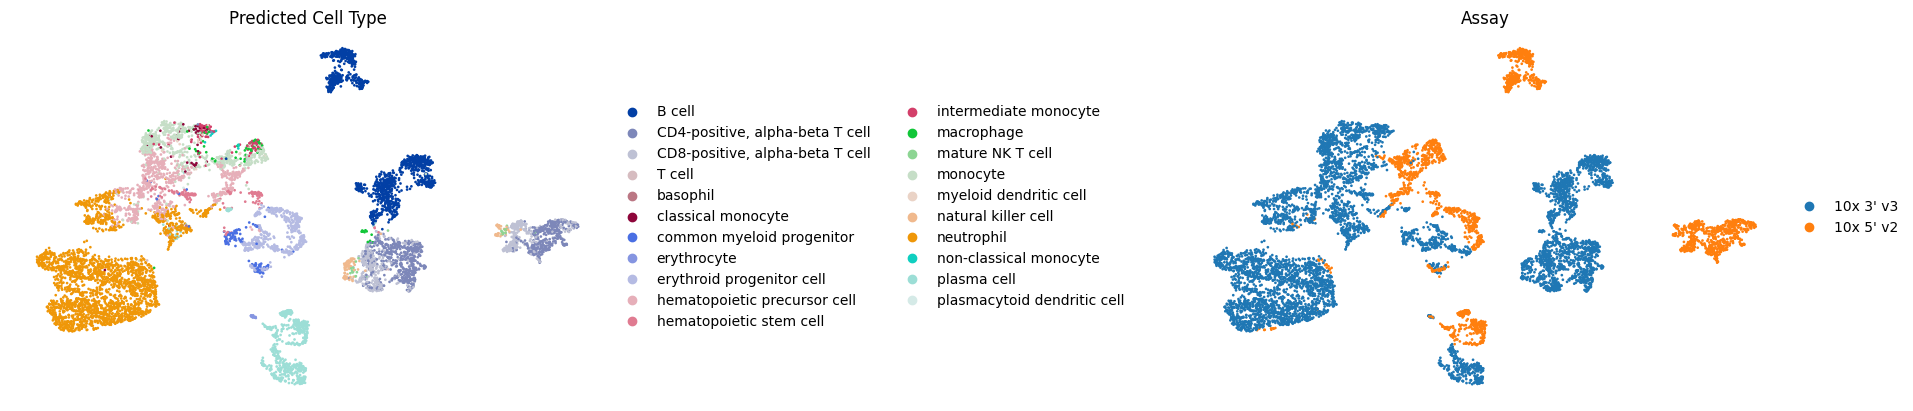

In [30]:
sc.pl.umap(
    adata_map, 
    color=['predicted_cell_type', "assay"], 
    ncols=2, 
    frameon=False,
    wspace=0.8,  # Add space between plots
    title=['Predicted Cell Type', 'Assay'],  # Add descriptive titles
)

Transcriptformer doesn't correct for assay or batch effect variation. We can see that the predicted cell types are not homogeneous across the two assays.
By plotting the true and predicted celltypes in the tabula sapiens v2 dataset, we can see that it recovers most of the major cell types.

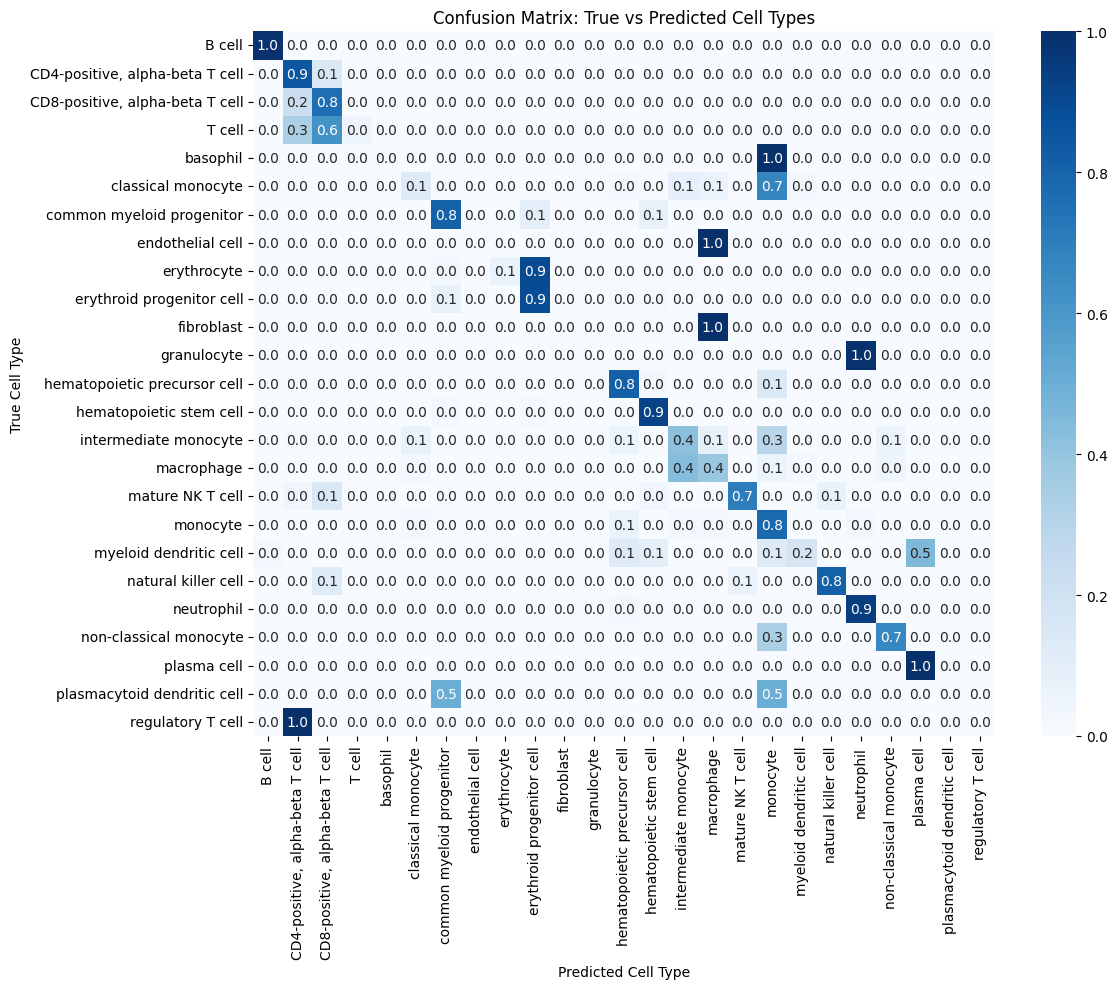

In [32]:
true_labels = adata_map.obs['cell_type']
pred_labels = adata_map.obs['predicted_cell_type']

# Get unique labels from both true and predicted
all_labels = np.unique(np.concatenate([true_labels.cat.categories, pred_labels.cat.categories]))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Cell Type')
plt.ylabel('True Cell Type')
plt.title('Confusion Matrix: True vs Predicted Cell Types')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
